In [1]:
import os
import pandas as pd
import numpy as np
import spacy
import matplotlib.pyplot as plt
import seaborn as sns
import timeit
import scattertext as st
import collections
from IPython.display import HTML, IFrame
from textblob import TextBlob
from w3lib.html import remove_tags
from wordcloud import WordCloud
from tqdm import tqdm_notebook
from sklearn.preprocessing import MinMaxScaler
from sklearn.manifold import TSNE
from sklearn.decomposition import KernelPCA
import warnings
warnings.filterwarnings("ignore")

In [2]:
import logging
logger = logging.getLogger("spacy")
logger.setLevel(logging.ERROR)

In [3]:
data1 = pd.read_csv("drugsComTrain_raw.tsv",sep='\t',index_col=0)
data2 = pd.read_csv("drugsComTest_raw.tsv",sep='\t',index_col=0)
data = pd.concat([data1,data2])
data.head()

,drugName,condition,review,rating,date,usefulCount
206461,Valsartan,Left Ventricular Dysfunction,"""It has no side effect, I take it in combinati...",9.0,"May 20, 2012",27
95260,Guanfacine,ADHD,"""My son is halfway through his fourth week of ...",8.0,"April 27, 2010",192
92703,Lybrel,Birth Control,"""I used to take another oral contraceptive, wh...",5.0,"December 14, 2009",17
138000,Ortho Evra,Birth Control,"""This is my first time using any form of birth...",8.0,"November 3, 2015",10
35696,Buprenorphine / naloxone,Opiate Dependence,"""Suboxone has completely turned my life around...",9.0,"November 27, 2016",37


In [4]:
df = data[['review','rating']]
df.head()

,review,rating
206461,"""It has no side effect, I take it in combinati...",9.0
95260,"""My son is halfway through his fourth week of ...",8.0
92703,"""I used to take another oral contraceptive, wh...",5.0
138000,"""This is my first time using any form of birth...",8.0
35696,"""Suboxone has completely turned my life around...",9.0


In [5]:
def train_val_test_split(df, val_size, test_size, random_state=0):
    """Split data frame into 3 (train/val/test) sets or into 2 (train/val) sets.
    
    If you want to split into two datasets, set test_size = 0.
    
    Parameters
    ----------
    df : pandas.DataFrame
        Pandas.DataFrame to split.
    val_size : float
        Fraction of dataset to include in validation set. Should be from range (0.0, 1.0).
    test_size : float
        Fraction of dataset to include in test set. Should be from range <0.0, 1.0).
    random_state: int, optional (default=0)
        The seed used by the random number generator.
    
    Returns
    -------
    train: pandas.DataFrame
       Training set.
    val: pandas.DataFrame
       Validation set.   
    test: pandas.DataFrame
       Test set.
    
    Raises
    ------
    AssertionError 
        If the val_size and test_size sum is greater or equal 1 or the negative value was passed.
    
    """
    assert (val_size + test_size) < 1, 'Validation size and test size sum is greater or equal 1'
    assert val_size >= 0 and test_size >= 0, 'Negative size is not accepted'
    train, val, test = np.split(df.sample(frac=1, random_state=random_state),
                                [int((1-(val_size+test_size))*len(df)), int((1-test_size)*len(df))])
    return train, val, test

In [79]:
dataset = data1[['review','rating']]
test_dataset = data2[['review','rating']]

In [80]:
print(dataset.shape)
print(test_dataset.shape)

(161297, 2)
(53766, 2)


In [12]:
dataset.rating.value_counts()

10.0    50989
9.0     27531
1.0     21619
8.0     18890
7.0      9456
5.0      8013
2.0      6931
3.0      6513
6.0      6343
4.0      5012
Name: rating, dtype: int64

In [13]:
dataset.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 161297 entries, 206461 to 215220
Data columns (total 2 columns):
review    161297 non-null object
rating    161297 non-null float64
dtypes: float64(1), object(1)
memory usage: 3.7+ MB


In [14]:
# Get indices of duplicate data (excluding first occurrence)
duplicate_indices = dataset.loc[dataset.duplicated(keep='first')].index

# Count and print the number of duplicates
print('Number of duplicates in the dataset: {}'.format(dataset.loc[duplicate_indices, 'review'].count()))

Number of duplicates in the dataset: 48879


In [15]:
dataset.loc[duplicate_indices, :].head()

,review,rating
109101,"""First had implanon then got Nexplanon, had a ...",9.0
183531,"""Prescribed via a Psychiatrist for severe Pani...",1.0
5154,"""I have only been on orsythia for about 1 mont...",2.0
186190,"""I have suffered from severe anxiety (GAD) and...",8.0
73940,"""I have been taking my first pack of Lo Loestr...",8.0


In [16]:
# Drop duplicates
dataset.drop_duplicates(keep='first', inplace=True)


In [81]:
test_dataset.drop_duplicates(keep='first', inplace=True)

In [82]:
# Print the shape of dataset after removing duplicate rows
print('Dataset shape after removing duplicates: {}'.format(dataset.shape))
print('Test Dataset shape after removing duplicates: {}'.format(test_dataset.shape))

Dataset shape after removing duplicates: (161297, 2)
Test Dataset shape after removing duplicates: (48302, 2)


In [18]:
dataset = dataset.dropna()

In [83]:
test_dataset = test_dataset.dropna()

In [24]:
# Save raw dataset as a CSV file
dataset.to_csv(os.path.join('drugreview/drugreview_raw.csv'), index=False)

In [86]:
test_dataset.to_csv(os.path.join('drugreview/drugreview_test_raw.csv'), index=False)

In [88]:
path = 'drugreview/'

# Load raw dataset from CSV file
dataset = pd.read_csv(os.path.join(path, 'drugreview_raw.csv'))

In [89]:
test_dataset = pd.read_csv(os.path.join(path, 'drugreview_test_raw.csv'))

In [90]:
def polarity(text):
    """Calculate the polarity score of the input text.
    
    """
    return TextBlob(text).sentiment.polarity

In [91]:
def subjectivity(text):
    """Calculate the subjectivity score of the input text.
    
    """
    return TextBlob(text).sentiment.subjectivity

In [92]:
def pos(df, batch_size, n_threads, required_tags):
    """Count the number of peculiar POS tags in data series of strings.
    
    Parameters
    ----------
    df : pandas.Series
        Pandas.Series containing strings to process.
    batch_size: int
        Size of text batch (recommended to be the power of 2).
    n_threads: int
        Number of threads in multiprocessing.
    required_tags: list
        List containing spacy's POS tags to count.
        
    Returns
    -------
    pandas.DataFrame
       DataFrame of a shape (index, len(required_tags)).
        
    """
    # Add index column to reviews frame and change column order
    reviews = df.reset_index(drop=False)[['review', 'index']]
    # Convert dataframe to list of tuples (review, index)
    review_list = list(zip(*[reviews[c].values.tolist() for c in reviews]))
    # Create empty dictionary
    review_dict = collections.defaultdict(dict)
    
    for doc, context in list(nlp.pipe(review_list, as_tuples=True, batch_size=batch_size)):
        review_dict[context] = {}
        for token in doc:
            pos = token.pos_
            if pos in required_tags:
                review_dict[context].setdefault(pos, 0)
                review_dict[context][pos] = review_dict[context][pos] + 1
    # Transpose data frame to shape (index, tags)
    return pd.DataFrame(review_dict).transpose()

In [93]:
def pos2(df, batch_size, n_threads, required_tags):
    """Count the number of peculiar POS tags in data series of strings.

    Parameters
    ----------
    df : pandas.Series
        Pandas.Series containing strings to process.
    batch_size: int
        Size of text batch (recommended to be the power of 2).
    n_threads: int
        Number of threads in multiprocessing.
    required_tags: list
        List containing spacy's POS tags to count.
        
    Returns
    -------
    pandas.DataFrame
       DataFrame of a shape (index, len(required_tags)).
        
    """
    # Create empty dictionary
    review_dict = collections.defaultdict(dict)
    for i, doc in enumerate(nlp.pipe(df, batch_size=batch_size)):
         for token in doc:
            pos = token.pos_
            if pos in required_tags:
                review_dict[i].setdefault(pos, 0)
                review_dict[i][pos] = review_dict[i][pos] + 1
    # Transpose data frame to shape (index, tags)
    return pd.DataFrame(review_dict).transpose()

In [94]:
def pos3(df, required_tags):
    """Count the number of peculiar POS tags in data series of strings.
    
    Parameters
    ----------
    df : pandas.Series
        Pandas.Series containing strings to process.
    required_tags: list
        List containing spacy's POS tags to count.
               
    Returns
    -------
    pandas.DataFrame
       DataFrame of a shape (index, len(required_tags)).
         
    """
    pos_list = []
    for i in range(df.shape[0]):
        doc = nlp(df[i])
        pos_dict = {}
        for token in doc:
            pos = token.pos_
            if pos in required_tags:
                pos_dict.setdefault(pos, 0)
                pos_dict[pos] = pos_dict[pos] + 1
        pos_list.append(pos_dict)
    return pd.DataFrame(pos_list)

In [31]:
# Load language model and disable unnecessary components of processing pipeline
nlp = spacy.load('en_core_web_sm', disable = ['ner', 'parser', 'textcat', '...'])
required_tags = ['PROPN', 'PUNCT', 'NOUN', 'ADJ', 'VERB']

# Define batch_size and n_threads
batch_size = 512
n_threads = 2

# Test the processing time on a part of the dataset, given batch_size and n_threads
start_time = timeit.default_timer()
print('Start processing 1000 examples using batch_size: {} and n_threads: {}'.format(batch_size, n_threads))
pos(dataset.loc[:1000, 'review'], required_tags=required_tags, batch_size=batch_size, n_threads=2)
print('Function 1 processing time: {:.2f} sec'.format(timeit.default_timer() - start_time))

Start processing 1000 examples using batch_size: 512 and n_threads: 2
Function 1 processing time: 5.35 sec


In [32]:
# Define batch_size and n_threads
batch_size = 512
n_threads = 2

# Test the processing time on a part of the dataset, given batch_size and n_threads
start_time = timeit.default_timer()
print('Start processing 1000 examples using batch_size: {} and n_threads: {}'.format(batch_size, n_threads))
pos2(dataset.loc[:1000, 'review'],  batch_size=batch_size, n_threads=2,required_tags=required_tags)
print('Function 2 processing time: {:.2f} sec'.format(timeit.default_timer() - start_time))

Start processing 1000 examples using batch_size: 512 and n_threads: 2
Function 2 processing time: 4.38 sec


In [33]:
# Test the processing time on a part of the dataset, given batch_size and n_threads
start_time = timeit.default_timer()
print('Start processing 1000 examples')
pos3(dataset.loc[:1000, 'review'], required_tags=required_tags)
print('Function 3 processing time: {:.2f} sec'.format(timeit.default_timer() - start_time))

Start processing 1000 examples
Function 3 processing time: 4.91 sec


In [34]:
def extract_features(df, batch_size, n_threads, required_tags):
    """Extract the following features from the data frame's 'review' column:
    polarity, subjectivity, word_count, UPPERCASE, DIGITS, and POS tags specified by required_tags.
    
    Convert extracted features to int16 or float16 data types.
    
    Parameters
    ----------
    df : pandas.DataFrame
        Pandas.DataFrame containing 'review' column to which extraction will be applied.
    batch_size: int
        Size of text batch (recommended to be the power of 2).
    n_threads: int
        Number of threads in multiprocessing.
    required_tags: list
        List containing spacy's POS tags to count.
        
    Returns
    -------
    pandas.DataFrame
       Concatenation of the original data frame and data frame containing extracted features.
        
    """
    # Calculate polarity
    df['polarity'] = df.review.apply(polarity).astype('float16')
    # Calculate subjectivity
    df['subjectivity'] = df.review.apply(subjectivity).astype('float16') 
    # Calculate number of words in review
    df['word_count'] = df.review.apply(lambda text: len(text.split())).astype('int16')
    # Count number of uppercase words, then divide by word_count
    df['UPPERCASE'] = df.review.apply(lambda text: len([word for word in text.split()\
                                                        if word.isupper()]))/df.word_count
    # Change data type to float16
    df.UPPERCASE = df.UPPERCASE.astype('float16')
    # Count number of digits, then divide by word_count
    df['DIGITS'] = df.review.apply(lambda text: len([word for word in text.split()\
                                                     if word.isdigit()]))/df.word_count
    # Change data type to float16
    df.DIGITS = df.DIGITS.astype('float16')
    # Perform part-of-speech taging
    pos_data = pos2(df.review, batch_size=batch_size, n_threads=n_threads, required_tags=required_tags)
    # Divide POS tags count by word_count
    pos_data = pos_data.div(df.word_count, axis=0).astype('float16')
    # Concatenate pandas data frames horizontaly
    return pd.concat([df, pos_data], axis=1)

In [35]:
# Load language model and disable unnecessary components of processing pipeline
nlp = spacy.load('en_core_web_sm', disable = ['ner', 'parser', 'textcat', '...'])
required_tags = ['PROPN', 'PUNCT', 'NOUN', 'ADJ', 'VERB']

batch_size = 512
n_threads = 2

# Test the processing time on a part of the trainig set, given batch_size and n_threads
start_time = timeit.default_timer()
print('Start processing 1000 examples using batch_size: {} and n_threads: {}'.format(batch_size, n_threads))
extract_features(dataset.loc[:1000, :], batch_size=batch_size, n_threads=n_threads, required_tags=required_tags)
print('Feature extraction function processing time: {:.2f} sec'.format(timeit.default_timer() - start_time))

Start processing 1000 examples using batch_size: 512 and n_threads: 2
Feature extraction function processing time: 5.94 sec


In [36]:
from tqdm.notebook import tqdm
def split_extract_save(df, name, path, part_size, batch_size, n_threads, required_tags, nlp):
    """Split data frame into chunks of size equal: part_size and perform feature extraction on each of the parts.
    Extract the following features from the data frame part's 'review' column: polarity, subjectivity, word_count,
    UPPERCASE, DIGITS, and POS tags specified by required_tags.
    
    Parameters
    ----------
    df : pandas.DataFrame
        Pandas.DataFrame containing 'review' column to which extraction will be applied.
    name : str
        Name of the CSV file to which export the data. 
    path : str
        Absolute or relative path to directory where to save the data. 
    part_size: int
        Size of the chunk to process (number of strings it contains).
    batch_size: int
        Size of text batch (recommended to be the power of 2).
    n_threads: int
        Number of threads in multiprocessing.
    required_tags: list
        List containing spacy's POS tags to count.
    nlp: spacy.lang.<language>
        Spacy language model (for example spacy.lang.en.English)
        
    Returns
    -------
    pandas.DataFrame
       Concatenation of the original data frame and data frame containing extracted features.
        
    """
    if name not in os.listdir(path):
        dataset_parts = []
        N = int(len(df)/part_size)
        # Create list of dataframe chunks
        data_frames = [df.iloc[i*part_size:(i+1)*part_size].copy() for i in range(N+1)]
        # Process dataset partialy 
        i = 0
        for frame in tqdm(data_frames):
            print(i)
            i += 1
            # Extract features from dataset chunk
            dataset_part = extract_features(frame, batch_size=batch_size, n_threads=n_threads,
                                            required_tags=required_tags)
            dataset_parts.append(dataset_part)
            # Reload nlp
            nlp = spacy.load('en_core_web_sm', disable = ['ner', 'parser', 'textcat', '...'])

        # Concatenate all parts into one dataset
        dataset_feat = pd.concat(dataset_parts, axis=0, sort=False)
        # Replace missing values NaN with 0
        dataset_feat.fillna(0, inplace=True)
        # Convert label values to int16
        dataset_feat.rating = dataset_feat.rating.astype('int16')
        # Export data frame to CSV file
        dataset_feat.to_csv(path + name, index=False)
    else:
        print('File {} already exists in given directory.'.format(name))    

In [39]:
# Define all required variables
nlp = spacy.load('en_core_web_sm', disable = ['ner', 'parser', 'textcat', '...'])
required_tags = ['PROPN', 'PUNCT', 'NOUN', 'ADJ', 'VERB']
batch_size = 512
n_threads = 2
part_size = 5000
path = os.path.join(os.getcwd(), 'drugreview/datasets_feat/')
name = 'drugreview_feat.csv'

# Perform feature extraction and export resulted file into CSV
split_extract_save(dataset, name, path, part_size, batch_size, n_threads, required_tags, nlp)

  0%|          | 0/12 [00:00<?, ?it/s]

0
1
2
3
4
5
6
7
8
9
10
11


In [99]:
# Define all required variables
nlp = spacy.load('en_core_web_sm', disable = ['ner', 'parser', 'textcat', '...'])
required_tags = ['PROPN', 'PUNCT', 'NOUN', 'ADJ', 'VERB']
batch_size = 512
n_threads = 2
part_size = 5000
path = os.path.join(os.getcwd(), 'drugreview/datasets_feat/')
name = 'drugreview_test_feat.csv'

# Perform feature extraction and export resulted file into CSV
split_extract_save(test_dataset, name, path, part_size, batch_size, n_threads, required_tags, nlp)

  0%|          | 0/10 [00:00<?, ?it/s]

0
1
2
3
4
5
6
7
8
9


In [100]:
# Dictionary of {column: dtype} pairs
col_types = {'review': str,'rating': np.int16, 'polarity': np.float16, 'subjectivity': np.float16,
             'word_count': np.int16, 'UPPERCASE': np.float16, 'DIGITS': np.float16, 'PROPN': np.float16,
             'VERB': np.float16, 'NOUN': np.float16, 'PUNCT': np.float16, 'ADJ': np.float16}

# Import dataset from the CSV file
dataset_feat = pd.read_csv('drugreview/datasets_feat/drugreview_feat.csv', dtype=col_types)

In [101]:
test_dataset_feat = pd.read_csv('drugreview/datasets_feat/drugreview_test_feat.csv', dtype=col_types)

In [41]:
dataset_feat.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 108368 entries, 0 to 108367
Data columns (total 12 columns):
review          108368 non-null object
rating          108368 non-null int16
polarity        108368 non-null float16
subjectivity    108368 non-null float16
word_count      108368 non-null int16
UPPERCASE       108368 non-null float16
DIGITS          108368 non-null float16
PUNCT           108368 non-null float16
VERB            108368 non-null float16
PROPN           108368 non-null float16
NOUN            108368 non-null float16
ADJ             108368 non-null float16
dtypes: float16(9), int16(2), object(1)
memory usage: 3.1+ MB


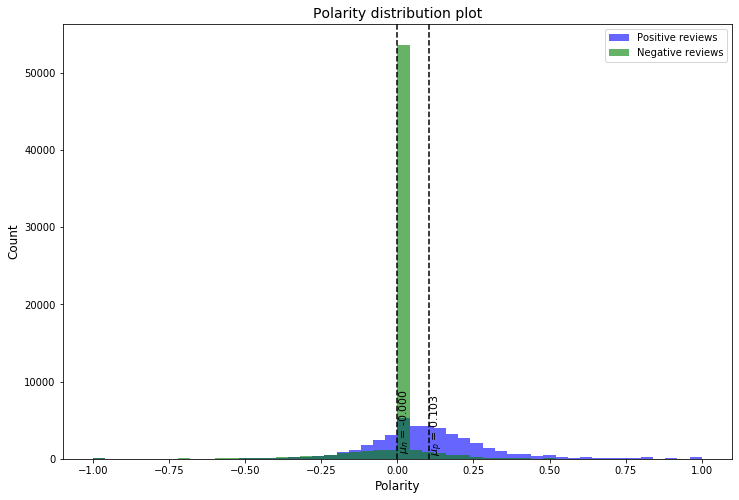

In [42]:
# Separate polarity score for positive and nagative reviews
pos_reviews_pol = dataset_feat.loc[dataset_feat.rating >= 5, 'polarity']
neg_reviews_pol = dataset_feat.loc[dataset_feat.rating < 5, 'polarity']

# Create a new figure
plt.figure(figsize=(12,8))

# Create a histogram of polarity for positive reviews (color=blue, transparency=0.6)
plt.hist(pos_reviews_pol, bins=50, label='Positive reviews', alpha=0.6, color='blue')
# Create a histogram of polarity for negative reviews (color=green, transparency=0.6)
plt.hist(neg_reviews_pol, bins=50, label='Negative reviews', alpha=0.6, color='green')
# Create the title, horizontal axis label, vertical axis label and legend for the histograms
plt.title('Polarity distribution plot', size=14)
plt.xlabel('Polarity', size=12)
plt.ylabel('Count', size=12)
plt.legend(loc='upper right')

# Calculate the mean value of polarity for positive and negative reviews
pos_pol_mean = pos_reviews_pol.mean()
neg_pol_mean = neg_reviews_pol.mean()

# Add vertical lines that represent the average polarity of each class
plt.axvline(pos_pol_mean, c='k', linestyle='--', linewidth=1.5)
plt.axvline(neg_pol_mean, c='k', linestyle='--', linewidth=1.5)
# Add annotations
plt.text(pos_pol_mean, 1200, r'$\mu_p$ = {:.3f}'.format(pos_pol_mean), rotation=90, size=11)
plt.text(neg_pol_mean, 1200, r'$\mu_n$ = {:.3f}'.format(neg_pol_mean), rotation=90, size=11)

plt.show()

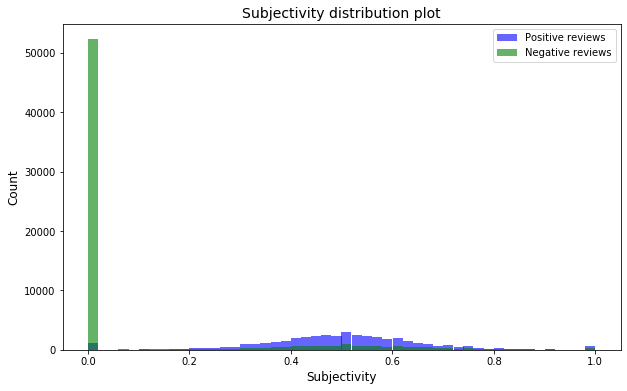

In [43]:
# Separate subjectivity score for positive and nagative reviews
pos_reviews_subj = dataset_feat.loc[dataset_feat.rating >=5, 'subjectivity']
neg_reviews_subj = dataset_feat.loc[dataset_feat.rating < 5, 'subjectivity']

# Create a new figure
plt.figure(figsize=(10,6))

# Create histograms of subjectivity for positive and negative reviews
plt.hist(pos_reviews_subj, bins=50, label='Positive reviews', alpha=0.6, color='blue')
plt.hist(neg_reviews_subj, bins=50, label='Negative reviews', alpha=0.6, color='green')
plt.title('Subjectivity distribution plot', size=14)
plt.xlabel('Subjectivity', size=12)
plt.ylabel('Count', size=12)
plt.legend(loc='upper right')

plt.show()

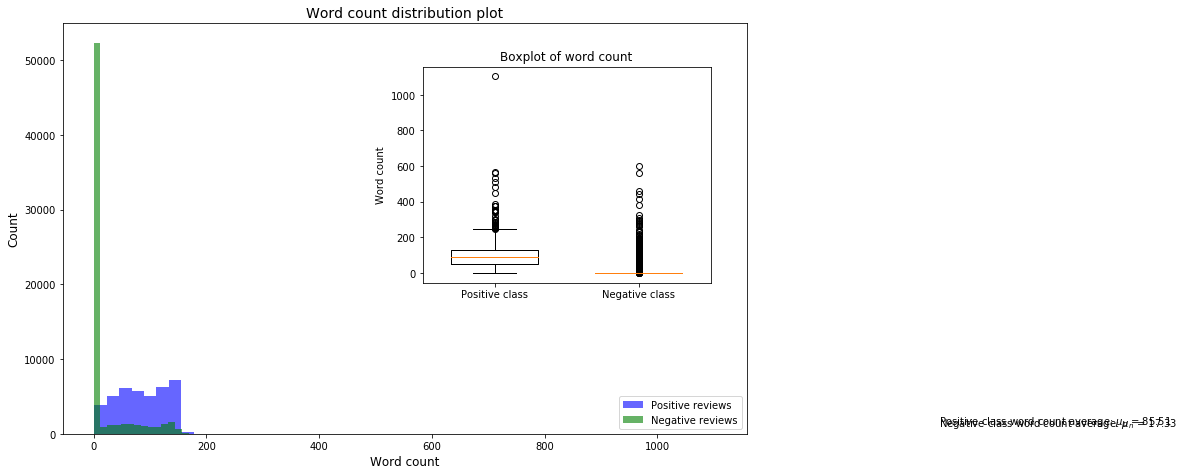

In [44]:
# Separate word count distributions for positive and nagative reviews 
# Violinplots or boxplots better deal with numpy arrays
pos_reviews_w_count = np.array(dataset_feat.loc[dataset_feat.rating >+ 5, 'word_count'])
neg_reviews_w_count = np.array(dataset_feat.loc[dataset_feat.rating < 5, 'word_count'])

# Create a new figure instance
fig = plt.figure(figsize=(10,6))

# Add axes to the figure. Create the first main window
ax1 = fig.add_axes([0, 0, 0.95, 0.95]) # window coord: (left, bottom, width, height)(in %)
ax1.hist(pos_reviews_w_count, bins=50, label='Positive reviews', alpha=0.6, color='blue')
ax1.hist(neg_reviews_w_count, bins=50, label='Negative reviews', alpha=0.6, color='green')
# Create the title, horizontal axis label, vertical axis label and legend for the histogram
ax1.set_title('Word count distribution plot', size=14)
ax1.set_xlabel('Word count', size=12)
ax1.set_ylabel('Count', size=12)
ax1.legend(loc='lower right')
# Add descriptions
ax1.text(1500, 1200, r'Positive class word count average: $\mu_p$ = {:.2f}'.format(pos_reviews_w_count.mean()))
ax1.text(1500, 1000, r'Negative class word count average: $\mu_n$ = {:.2f}'.format(neg_reviews_w_count.mean()))

# Add axes to the figure. Create the second boxplots window
ax2 = fig.add_axes([0.5, 0.35, 0.40, 0.50]) # window coord: (left, bottom, width, height)(in %)
# Create boxplots
ax2.boxplot([pos_reviews_w_count, neg_reviews_w_count], widths=0.6)
ax2.set_title('Boxplot of word count')
ax2.set_ylabel('Word count')
# Set the x axis labels
ax2.set_xticks([1, 2])
ax2.set_xticklabels(['Positive class', 'Negative class'])

plt.show()

In [45]:
dataset_feat.groupby(by='rating').word_count.describe()

,count,mean,std,min,25%,50%,75%,max
rating,,,,,,,,
0,51684.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0
1,7592.0,78.323235,45.445657,1.0,41.0,73.0,119.0,601.0
2,2423.0,82.860091,42.835462,2.0,47.0,82.0,122.5,298.0
3,2281.0,83.859272,42.044149,2.0,49.0,83.0,124.0,216.0
4,1788.0,85.553691,42.035119,1.0,51.0,85.0,125.0,287.0
5,2825.0,88.042832,42.066123,2.0,53.0,89.0,127.0,375.0
6,2259.0,86.830899,42.652547,1.0,52.0,87.0,127.0,260.0
7,3330.0,89.367267,43.465768,1.0,54.0,91.0,129.0,566.0
8,6515.0,88.872141,43.677508,1.0,54.0,91.0,129.0,558.0


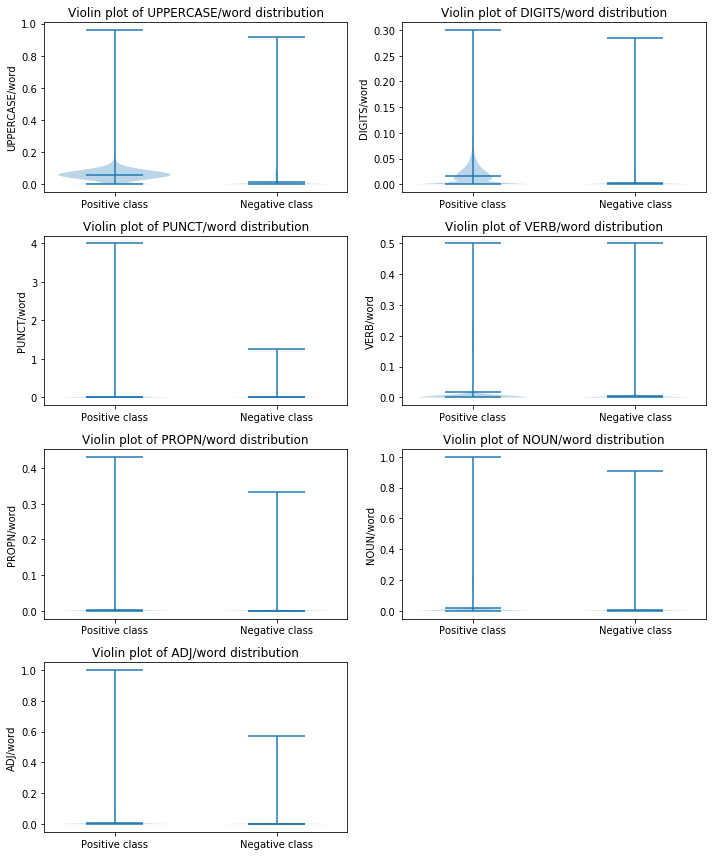

In [46]:
# Create the figure and axes instances
fig, axes = plt.subplots(4, 2, figsize=(10,12), sharex=False)
# Take the last 7 columns labels from the data frame
data_labels = dataset_feat.columns[-7:]
data_idx = 0

# Iterate through the plots rows and columns
for row in range(4):
    for col in range(2):
        if data_idx <= 6: 
            # Create the violinplot of given feature for positive and negative examples
            axes[row, col].violinplot([np.array(dataset_feat.loc[dataset_feat.rating >= 5, data_labels[data_idx]]),
                                      np.array(dataset_feat.loc[dataset_feat.rating < 5, data_labels[data_idx]])],
                                      widths=0.7, showmeans=True)
            # Set the title and vertical axis labels
            axes[row, col].set_title('Violin plot of {}/word distribution'.format(data_labels[data_idx]))
            axes[row, col].set_ylabel('{}/word'.format(data_labels[data_idx]))
            # Set the x axis labels
            axes[row, col].set_xticks([1, 2])
            axes[row, col].set_xticklabels(['Positive class', 'Negative class'])
        else:
            # Delete unnecessary axes
            fig.delaxes(axes[row, col])
        data_idx += 1
        
# Automatically adjusts subplot params to fit in figure       
plt.tight_layout()

In [47]:
# Choose at random a sample of 10,000 examples to visualize
data_to_vis = dataset_feat.iloc[:, -11:].sample(n=10000)
feat_to_vis = data_to_vis.iloc[:, -10:]
label_to_vis = data_to_vis.iloc[:, 0]

# Perform MinMax feature scaling
feat_to_vis = MinMaxScaler().fit_transform(feat_to_vis)

# Perform dimensionality reduction using t-SNE
emb_vectors = TSNE(n_components=2, n_iter=1000).fit_transform(feat_to_vis)

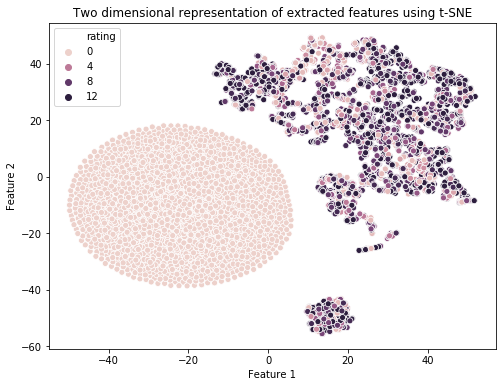

In [48]:
#Visualize data in lower-dimensional space
plt.figure(figsize=(8,6))
# Create seaborn scatterplot
sns.scatterplot(x=emb_vectors[:, 0], y=emb_vectors[:, 1], hue=label_to_vis)
plt.title('Two dimensional representation of extracted features using t-SNE')
plt.xlabel('Feature 1')
plt.ylabel('Feature 2')
plt.show()

In [49]:
# Perform dimensionality reduction using kernel PCA
emb_vectorsPCA = KernelPCA(n_components=2, kernel='rbf').fit_transform(feat_to_vis)

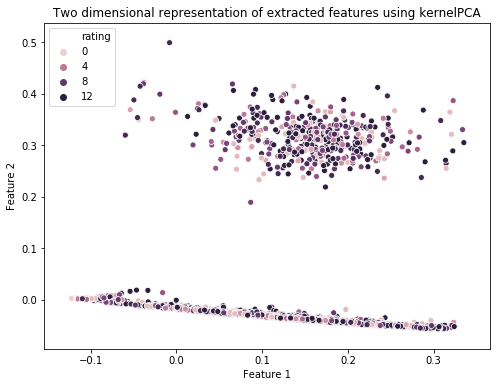

In [50]:
# Visualize data in lower-dimensional space
plt.figure(figsize=(8,6))
sns.scatterplot(x=emb_vectorsPCA[:, 0], y=emb_vectorsPCA[:, 1], hue=label_to_vis)
plt.title('Two dimensional representation of extracted features using kernelPCA')
plt.xlabel('Feature 1')
plt.ylabel('Feature 2')
plt.show()

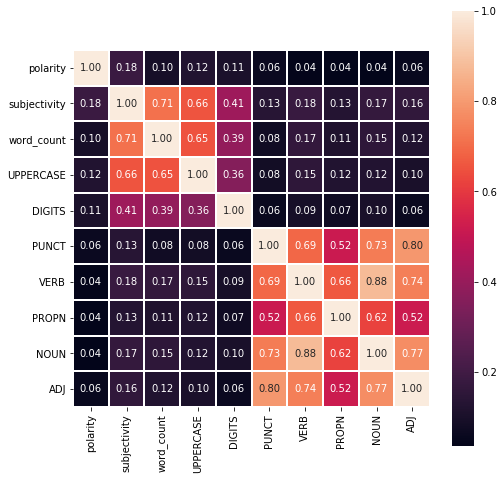

In [51]:
# Calculate correlations between the features
corr_matrix = dataset_feat.iloc[:, 2:].corr()

# Plot correlation matrix
plt.figure(figsize=(8,8))
ax = sns.heatmap(corr_matrix, annot=True, fmt='.2f', linewidths=1, square=True)
# Set limit of y axis. To check current settings use: ax.get_ylim()
ax.set_ylim(10,0)
plt.show()

In [102]:
# Import the dataset
dataset_feat = pd.read_csv('drugreview/datasets_feat/drugreview_feat.csv')
dataset_test_feat = pd.read_csv('drugreview/datasets_feat/drugreview_test_feat.csv')

In [103]:
def token_filter(token):
    """Filter the token for text_preprocessing function.
    Check if the token is not: punctuation, whitespace, stopword or digit.
    
    Parameters
    ----------
    token : spacy.Token
        Token passed from text_preprocessing function.

    Returns
    -------
    Bool
       True if token meets the criteria, otherwise False.
        
    """
    return not (token.is_punct | token.is_space | token.is_stop | token.is_digit | token.like_num)

def text_preprocessing(df, batch_size, n_threads):
    """Perform text preprocessing using the following methods: removing HTML tags, lowercasing, 
    lemmatization and removing stopwords, whitespaces, punctuations, digits. 

    Parameters
    ----------
    df : pandas.Series
        Pandas.Series containing strings to process.
    batch_size: int
        Size of text batch (recommended to be the power of 2).
    n_threads: int
        Number of threads in multiprocessing.
        
    Returns
    -------
    pandas.Series
       Pandas.Series containing processed strings.
        
    """
    # Remove HTML tags
    df = df.apply(remove_tags)
    # Make lowercase
    df = df.str.lower()
    processed_docs = []
    for doc in list(nlp.pipe(df, batch_size=batch_size)):
        # Remove stopwords, spaces, punctutations and digits
        text = [token for token in doc if token_filter(token)]
        # Lemmatization
        text = [token.lemma_ for token in text if token.lemma_ != '-PRON-']
        processed_docs.append(' '.join(text))
    return pd.Series(processed_docs, name='clean_review', index=df.index) 

In [54]:
# Define the variables
import warnings
warnings.filterwarnings('ignore')
warnings.simplefilter('ignore')
nlp = spacy.load('en_core_web_sm', disable = ['ner', 'parser', 'textcat', 'tagger', '...'])
batch_size = 512
n_threads = 2

# Test the processing time on a part of the trainig set, given batch_size and n_threads
print('Start processing 1000 examples using batch_size: {} and n_threads: {}'.format(batch_size, n_threads))
start_time = timeit.default_timer()
text_preprocessing(dataset_feat.loc[:1000, 'review'], batch_size=batch_size, n_threads=n_threads)
print('Processing time: {:.2f} sec'.format(timeit.default_timer() - start_time))

Start processing 1000 examples using batch_size: 512 and n_threads: 2
Processing time: 4.39 sec


In [104]:
def split_norm_save(df, name, path, part_size, batch_size, n_threads, nlp):
    """Split data frame into chunks of size equal: part_size and perform text preprocessing on each of the parts.
    Preprocess strings using the following methods: removing HTML tags, lowercasing, lemmatization and 
    removing stopwords, whitespaces, punctuations, digits. 
    
    Parameters
    ----------
    df : pandas.DataFrame
        Pandas.DataFrame containing 'review' column to preprocess.
    name : str
        Name of the CSV file to which export the data. 
    path : str
        Absolute or relative path to directory where to save the data. 
    part_size: int
        Size of the chunk to process (number of strings it contains).
    batch_size: int
        Size of text batch (recommended to be the power of 2).
    n_threads: int
        Number of threads in multiprocessing.
    nlp: spacy.lang.<language>
        Spacy language model (for example spacy.lang.en.English)
        
    Returns
    -------
    pandas.DataFrame
       Concatenation of the original data frame and pandas series of normalized strings.
        
    """
    from tqdm.notebook import tqdm
    if name not in os.listdir(path):
        dataset_parts = []
        N = int(len(df)/part_size)
        # Create list of dataframe chunks
        data_frames = [df.iloc[i*part_size:(i+1)*part_size, 0].copy() for i in range(N+1)]
        print(len(data_frames))
        # Process dataset partialy 
        i = 0
        for frame in tqdm(data_frames):
            # Normalize dataset chunk
            print(i)
            i += 1
            dataset_part = text_preprocessing(frame, batch_size=batch_size, n_threads=n_threads)
            dataset_parts.append(dataset_part)
            # Reload nlp
            nlp = spacy.load('en_core_web_sm', disable = ['ner', 'parser', 'textcat', '...'])

        # Concatenate all parts into one series
        concat_clean = pd.concat(dataset_parts, axis=0, sort=False)
        # Concatenate dataset and cleaned review seires
        dataset_clean = pd.concat([df, concat_clean], axis=1)        
        # Export data frame to CSV file
        dataset_clean.to_csv(path + name, index=False)
    else:
        print('File {} already exists in given directory.'.format(name)) 

In [56]:
# Define variables
nlp = spacy.load('en_core_web_sm', disable = ['ner', 'parser', 'textcat', 'tagger', '...'])
batch_size = 512
n_threads = 2
part_size = 5000
path = os.path.join(os.getcwd(), 'drugreview/datasets_feat_clean/')
name = 'drugreview_feat_clean.csv'

# Perform text preprocessing and save the resulted frame to CSV file
split_norm_save(dataset_feat, name, path, part_size, batch_size, n_threads, nlp)


22


  0%|          | 0/22 [00:00<?, ?it/s]

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21


In [105]:
# Define variables
nlp = spacy.load('en_core_web_sm', disable = ['ner', 'parser', 'textcat', 'tagger', '...'])
batch_size = 512
n_threads = 2
part_size = 5000
path = os.path.join(os.getcwd(), 'drugreview/datasets_feat_clean/')
name = 'drugreview_test_feat_clean.csv'

# Perform text preprocessing and save the resulted frame to CSV file
split_norm_save(dataset_test_feat, name, path, part_size, batch_size, n_threads, nlp)

19


  0%|          | 0/19 [00:00<?, ?it/s]

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18


In [109]:
# Import preprocessed dataset from CSV file
dataset_feat_clean = pd.read_csv('drugreview/datasets_feat_clean/drugreview_feat_clean.csv')
dataset_test_feat_clean = pd.read_csv('drugreview/datasets_feat_clean/drugreview_test_feat_clean.csv')

In [59]:
# Display the random review before normalization
idx = np.random.randint(dataset_feat_clean.shape[0])
HTML(dataset_feat_clean.loc[idx, 'review'])

In [60]:
# Display normalized review
HTML(dataset_feat_clean.loc[idx, 'clean_review'])

In [61]:
# Load the language model
nlp = spacy.load('en_core_web_sm')

# Create the data frame that contains positive and neagtive reviews to visualize
pos_to_visual = dataset_feat_clean.loc[dataset_feat_clean.rating >= 5, ['clean_review', 'rating']].head(1500).copy()
neg_to_visual = dataset_feat_clean.loc[dataset_feat_clean.rating < 5, ['clean_review', 'rating']].head(1500).copy()
data_to_visual = pd.concat([pos_to_visual, neg_to_visual], axis=0)
# Replace numerical labels by strings (required by scattertext)
data_to_visual.rating = data_to_visual.rating.replace([10,9,8,7,6,5,4,3,2,1,0], ['pos', 'pos','pos','pos','pos','pos','neg','neg','neg','neg','neg'])

In [62]:
# Create the Scattertext corpus
corpus = st.CorpusFromPandas(data_to_visual,
                             category_col='rating',
                             text_col='clean_review',
                             nlp=nlp).build()

In [63]:
# Create the scattertext plot
html = st.produce_scattertext_explorer(corpus,
          category='pos',
          category_name='Positive reviews',
          not_category_name='Negative reviews',
          width_in_pixels=600,
          height_in_pixels=500)
# Save the visualization as HTML file
open('assets/scattertext_visualization.html', 'wb').write(html.encode('utf-8'))

1621173

In [64]:
data_to_visual.loc[data_to_visual.rating =='neg', 'clean_review']

17      irregular inconsistency pain control break pai...
20            breo didn&#039;t help asthma bright effects
23      life blood pressure medication horror story ba...
25      months taking drug stop effects painful weakne...
27      i&#039;ve bad reactions mood stabilizer i&#039...
                              ...                        
5280                                                  NaN
5281                                                  NaN
5282                                                  NaN
5283                                                  NaN
5284                                                  NaN
Name: clean_review, Length: 1500, dtype: object

In [65]:
data_to_visual.shape

(3000, 2)

In [66]:
data_to_visual = data_to_visual.dropna()


In [67]:
# Separate positive and negative reviews and then concatenate all reviews within given group
pos_reviews = ' '.join(data_to_visual.loc[data_to_visual.rating =='pos', 'clean_review'])
neg_reviews = ' '.join(data_to_visual.loc[data_to_visual.rating =='neg', 'clean_review'])

In [68]:
# Create wordcloud for positive reviews
wordcloud_pos = WordCloud(background_color='black',
                      width=600,
                      height=500).generate(pos_reviews)

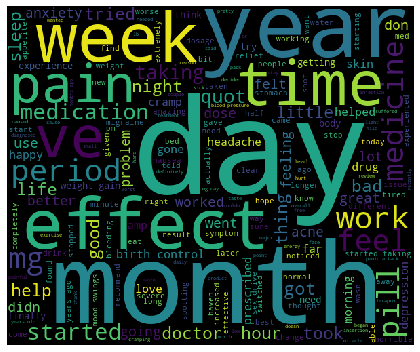

In [69]:
# Depict wordcloud for positive reviews
plt.figure(figsize=(8,5))
plt.imshow(wordcloud_pos)
plt.axis('off')
plt.tight_layout()

In [70]:
# Create wordcloud for negative reviews
wordcloud_neg = WordCloud(background_color='black',
                      width=600,
                      height=500).generate(neg_reviews)

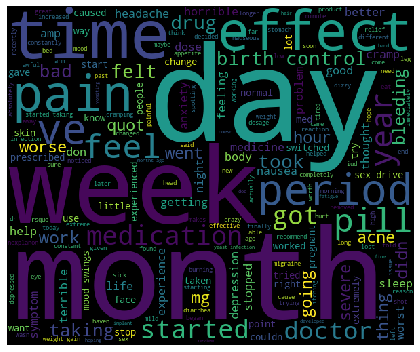

In [71]:
# Depict wordcloud for negative reviews
plt.figure(figsize=(8,5))
plt.imshow(wordcloud_neg)
plt.axis('off')
plt.tight_layout()

In [107]:
# Split entire raw dataset into training, validation and test sets
train_set, val_set, test1_set = train_val_test_split(dataset_feat_clean, val_size=0.20, test_size=0.0)

In [110]:
# Check training, validation and test sets shapes
print('Training set shape: {}'.format(train_set.shape))
print('Validation set shape: {}'.format(val_set.shape))
print('Test set shape: {}'.format(dataset_test_feat_clean.shape))

Training set shape: (86694, 13)
Validation set shape: (21674, 13)
Test set shape: (91604, 13)


In [112]:
# Save training, validation and test sets to CSV files
train_set.to_csv('drugreview/drugreview_feat_clean/train_feat_clean.csv', index=False)
val_set.to_csv('drugreview/drugreview_feat_clean/val_feat_clean.csv', index=False)
dataset_test_feat_clean.to_csv('drugreview/drugreview_feat_clean/test_feat_clean.csv', index=False)

In [113]:
dataset_feat_clean.head()

,review,rating,polarity,subjectivity,word_count,UPPERCASE,DIGITS,PUNCT,VERB,PROPN,NOUN,ADJ,clean_review
0,"""I have been taking Seroquel for a number of y...",10,0.10190,0.5825,133.0,0.04510,0.00000,0.09020,0.2482,0.030080,0.2030,0.08270,taking seroquel number years prescribed numero...
1,"""I tried the MYLAN 5% patches that the VA pres...",7,0.29150,0.4507,140.0,0.12140,0.00000,0.12850,0.1571,0.078550,0.1571,0.07855,tried mylan patches va prescribes like vets ac...
2,"""I have been on 10 MG Norco for four years due...",9,-0.00238,0.5100,106.0,0.09436,0.01888,0.09436,0.1698,0.075500,0.1604,0.01888,mg norco years arm pain helps lot especially m...
3,"""I went to my dermatologist after suffering th...",9,-0.03268,0.3108,143.0,0.05594,0.00000,0.13990,0.1958,0.006992,0.1818,0.10490,went dermatologist suffering teenage years acn...
4,"""Works great for me, very effective.""",10,0.79000,0.8750,6.0,0.00000,0.00000,0.66650,0.1666,0.000000,0.0000,0.33330,works great effective
